A notebook mofdified from the work of Bjorn in the new enviroment, with code updates...in progress March 2022

# Prepare EEG data for training of machine-learning models

In this notebook, the preprocessing for machine learning purposes is done. Also, some exploration and visualization is done to better understand the data at hand.

+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.
+ Extract features
+ Select features

## Import packages & links

In [1]:
# Import packages
import os
import sys

sys.path.insert(0, os.path.dirname(os.getcwd()))

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

sns.set_theme(style="whitegrid")
%matplotlib inline
# %matplotlib qt

In [3]:
from config_for_repro_prepro import PATH_RAW_DATA, PATH_METADATA, PATH_DATA_PROCESSED_ML
import re
from itertools import islice

In [4]:
PATH_DATA_PROCESSED_ML

'C:/Projects\\EEG_explorer\\Data/data_processed_ML/'

In [5]:
import fnmatch
import warnings
import re
warnings.filterwarnings('ignore')
sys.path.insert(0,'C:/Projects/ePodium/eegyolk')
#from TMSiSDK.file_readers import Poly5Reader
from eegyolk import helper_functions

## Search all *.cnt files from the Bjorn set and get paths, code, and age group

In [6]:
dir_names = {11: '11mnd mmn',
             17: '17mnd mmn',
             23: '23mnd mmn',
             29: '29mnd mmn',
             35: '35mnd mmn',
             41: '41mnd mmn',
             47: '47mnd mmn'}
    
df_list = []

for age_group, directory in dir_names.items(): # Go into every age group folder        
    dir_path = os.path.join('C:/Projects/EEG_explorer/Data', directory)
    file_names = os.listdir(dir_path)
    
    cnt_paths = [os.path.join(dir_path, file_name) for file_name in fnmatch.filter(file_names, "*.cnt")]
    # list comprehension - creates a list of all cnt file names with thisdirectory
    cnt_files = [os.path.basename(x)[:-4] for x in cnt_paths]
    # list comprehension
    codes = [int(re.search(r'\d+', x).group()) for x in cnt_files]
    # takes number out of string (\d+ takes out digits)
    df = pd.DataFrame(list(zip(codes, cnt_paths, cnt_files)), columns=['code', 'cnt_path','cnt_file']) 
    
    df['age_group'] = age_group
    df_list.append(df)

cnt_files = pd.concat(df_list)

In [7]:
cnt_files.tail()

,code,cnt_path,cnt_file,age_group
39,704,C:/Projects/EEG_explorer/Data\47mnd mmn\704-03...,704-032-47m-jr-mmn36,47
40,705,C:/Projects/EEG_explorer/Data\47mnd mmn\705-05...,705-050-47m-jr-mmn36,47
41,709,C:/Projects/EEG_explorer/Data\47mnd mmn\709-07...,709-078-47m-jr-mmn36,47
42,710,C:/Projects/EEG_explorer/Data\47mnd mmn\710-07...,710-078-47m-jr-mmn36,47
43,711,C:/Projects/EEG_explorer/Data\47mnd mmn\711-08...,711-085-47m-jr-mmn36,47


In [8]:
# add a hash to the cnt_files

In [9]:
cnt_files

,code,cnt_path,cnt_file,age_group
0,1,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk,11
1,3,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp,11
2,4,C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...,004_11_mc_mmn,11
3,5,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2,11
4,7,C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...,007_11_jc_mmn2_36_wk,11
...,...,...,...,...
39,704,C:/Projects/EEG_explorer/Data\47mnd mmn\704-03...,704-032-47m-jr-mmn36,47
40,705,C:/Projects/EEG_explorer/Data\47mnd mmn\705-05...,705-050-47m-jr-mmn36,47
41,709,C:/Projects/EEG_explorer/Data\47mnd mmn\709-07...,709-078-47m-jr-mmn36,47
42,710,C:/Projects/EEG_explorer/Data\47mnd mmn\710-07...,710-078-47m-jr-mmn36,47


## Search for all age files and create DataFrame containing all ages per subject code

In [10]:

age_files = {11: 'ages_11mnths.txt',
             17: 'ages_17mnths.txt',
             23: 'ages_23mnths.txt',
             29: 'ages_29mnths.txt',
             35: 'ages_35mnths.txt',
             41: 'ages_41mnths.txt',
             47: 'ages_47mnths.txt'}

df_list = []

for age_group, age_file in age_files.items():
    df = pd.read_csv(os.path.join(PATH_METADATA, 'ages', age_file), sep="\t")
    # read the txts like csvs
    df['age_group'] = age_group
    df_list.append(df)

age_df = pd.concat(df_list)

In [11]:
age_df.head()

,code,age_days,age_months,age_years,age_group
0,1,329,10.966667,0.913889,11
1,3,336,11.200000,0.933333,11
2,5,329,10.966667,0.913889,11
3,6,319,10.633333,0.886111,11
4,7,329,10.966667,0.913889,11


### Merge the .cnt files with the age information we have on the subjects

In [12]:
# cnt_files['cnt_file'] = cnt_files['cnt_file'].astype(str)
# cnt_files['cnt_path'] = cnt_files['cnt_path'].astype(str)
# #MergeDat['Motor'] = MergeDat['Motor'].astype(str)
# type(cnt_files.cnt_path[5])

In [13]:
merged_df = pd.merge(age_df, cnt_files, how='left', on=['age_group','code'])

In [14]:
len(merged_df), len(cnt_files['cnt_path']), len(age_df)

(2602, 2149, 1717)

In [15]:
merged_df.age_months.unique()

array([10.96666667, 11.2       , 10.63333333, 11.13333333, 10.93333333,
       11.1       , 11.        , 10.9       , 11.23333333, 11.03333333,
       11.3       , 12.        , 10.86666667, 10.83333333, 11.5       ,
       11.16666667, 12.06666667, 10.8       , 11.33333333, 10.76666667,
       11.4       , 11.26666667, 11.36666667, 11.06666667, 11.53333333,
       11.7       , 11.43333333, 10.06666667, 11.66666667, 10.73333333,
       10.7       , 11.6       , 11.56666667, 11.73333333, 17.46666667,
       16.9       , 17.6       , 17.06666667, 17.13333333, 17.1       ,
       16.8       , 16.96666667, 17.3       , 16.56666667, 16.86666667,
       17.        , 17.2       , 16.93333333, 17.36666667, 17.03333333,
       17.63333333, 17.16666667, 17.53333333, 16.76666667, 16.46666667,
       17.26666667, 16.83333333, 16.73333333, 17.43333333, 16.63333333,
       16.6       , 17.5       , 17.56666667, 17.4       , 17.33333333,
       16.66666667, 17.23333333, 16.7       , 23.03333333, 23.36

In [16]:
merged_df.head()

,code,age_days,age_months,age_years,age_group,cnt_path,cnt_file
0,1,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk
1,1,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\1_naki...,1_nakijken_mmn3-6
2,3,336,11.200000,0.933333,11,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp
3,5,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2
4,6,319,10.633333,0.886111,11,NaN,NaN


In [17]:
(~merged_df['cnt_path'].isna()).sum()

2076

In [18]:
merged_df.columns

Index(['code', 'age_days', 'age_months', 'age_years', 'age_group', 'cnt_path',
       'cnt_file'],
      dtype='object')

In [19]:
len(merged_df)

2602

## Visualize the age ranges within groups

In [20]:
data_11 = merged_df.loc[merged_df['age_group'] == 11]
data_17 = merged_df.loc[merged_df['age_group'] == 17]
data_23 = merged_df.loc[merged_df['age_group'] == 23]
data_29 = merged_df.loc[merged_df['age_group'] == 29]
data_35 = merged_df.loc[merged_df['age_group'] == 35]
data_41 = merged_df.loc[merged_df['age_group'] == 41]
data_47 = merged_df.loc[merged_df['age_group'] == 47]
data = [data_11, data_17, data_23, data_29, data_35, data_41, data_47]

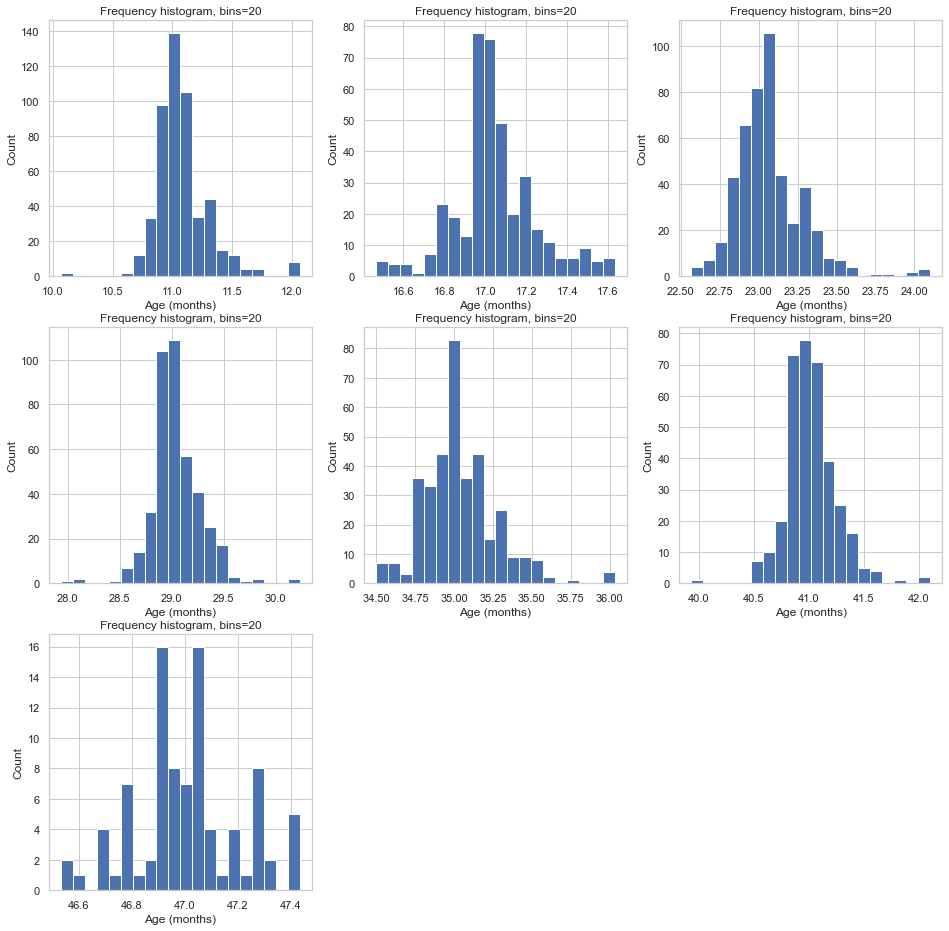

In [21]:
%matplotlib inline

bins = 20

fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:
        ax.hist(data[i]['age_months'], bins=bins)
        ax.set_xlabel('Age (months)')
        ax.set_ylabel('Count')
        ax.set_title(f'Frequency histogram, bins={bins}')

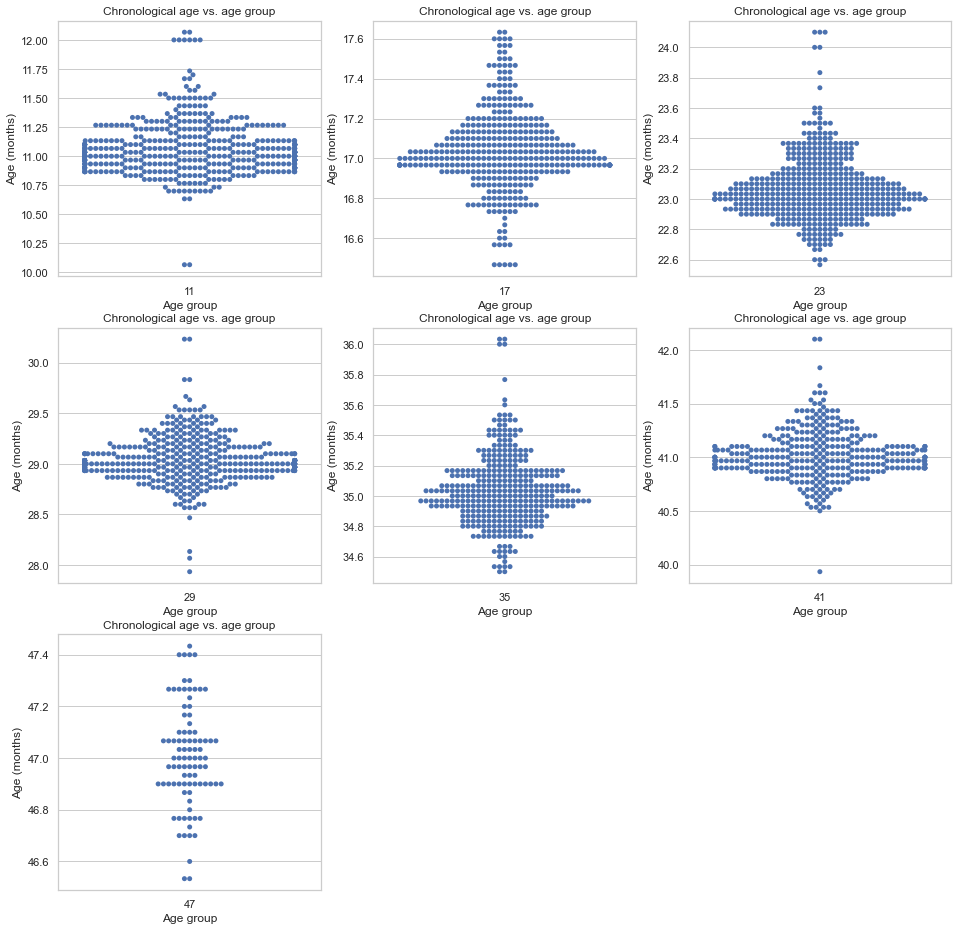

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:
        sns.swarmplot(ax=ax, x="age_group", y="age_months", data=data[i])
        ax.set_xlabel('Age group')
        ax.set_ylabel('Age (months)')
        ax.set_title('Chronological age vs. age group')

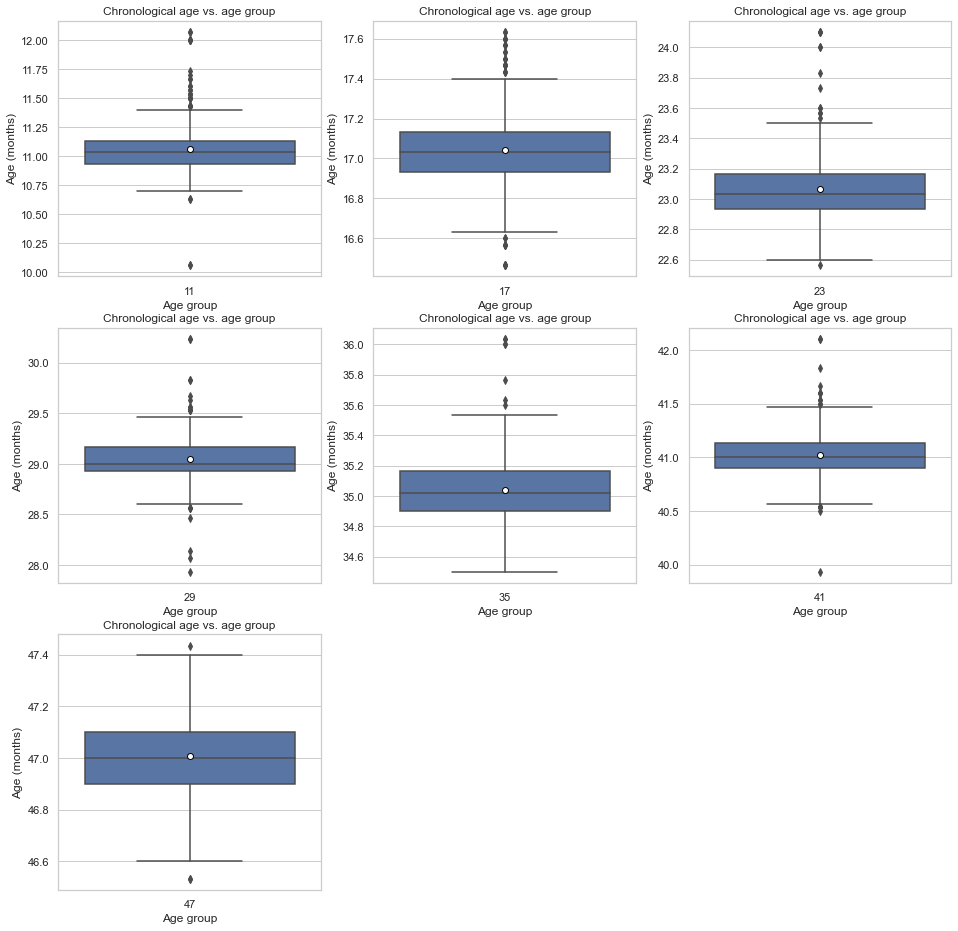

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:    
        sns.boxplot(ax=ax, x="age_group", y="age_months", data=data[i], showmeans=True, 
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                           "markersize":"6"})
        ax.set_xlabel('Age group')
        ax.set_ylabel('Age (months)')
        ax.set_title('Chronological age vs. age group')

## Check files with no label 

In [24]:
merged_df.loc[merged_df['age_days'].isnull()]

,code,age_days,age_months,age_years,age_group,cnt_path,cnt_file


### Fill in the missing age data based on the age group the subject is in

We know the age group (i.e. 11, 17, 23, .. months etc) of all the subjects, based on the folder the files are in and based on the file name. We have got the exact ages (in days) of most subjects seperately, which we have added to the DataFrame above. For some of the subjects, we don't have the exact age and therefore we set this equal to the age group.

In [25]:
merged_df['age_months'].fillna(merged_df['age_group'], inplace=True)
merged_df['age_days'].fillna(merged_df['age_group']*30, inplace=True)
merged_df['age_years'].fillna(merged_df['age_group']/12, inplace=True)

Below should now return an empty dataframe, because all empty fields have been filled

In [26]:
merged_df.loc[merged_df['age_days'].isnull()]

,code,age_days,age_months,age_years,age_group,cnt_path,cnt_file


In [27]:
merged_df

,code,age_days,age_months,age_years,age_group,cnt_path,cnt_file
0,1,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk
1,1,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\1_naki...,1_nakijken_mmn3-6
2,3,336,11.200000,0.933333,11,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp
3,5,329,10.966667,0.913889,11,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2
4,6,319,10.633333,0.886111,11,NaN,NaN
...,...,...,...,...,...,...,...
2597,731,1409,46.966667,3.913889,47,NaN,NaN
2598,732,1412,47.066667,3.922222,47,NaN,NaN
2599,733,1404,46.800000,3.900000,47,NaN,NaN
2600,734,1405,46.833333,3.902778,47,NaN,NaN


## Explore EEG data

### Import EEG data (from .cnt files)

In [28]:
#merged_df.loc[50]
merged_df['cnt_path'][50]

'C:/Projects/EEG_explorer/Data\\11mnd mmn\\103_11_mr_mmn2.cnt'

In [29]:
# Select a file
file = merged_df['cnt_path'][50] # just a random file number

# Import file 
data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True)

Reading 0 ... 739079  =      0.000 ...  1478.158 secs...


## What does the data look like?

In [30]:
print('Data type: {}\n\n{}\n'.format(type(data_raw), data_raw))

# Get the sample rate
print('Sample rate:', data_raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(data_raw.get_data().shape))

# The mne.info class can be used to learn more about the data.
print(data_raw.info)

Data type: <class 'mne.io.cnt.cnt.RawCNT'>

<RawCNT | 103_11_mr_mmn2.cnt, 64 x 739080 (1478.2 s), ~360.9 MB, data loaded>

Sample rate: 500.0 Hz
Size of the matrix: (64, 739080)

<Info | 8 non-empty values
 bads: []
 ch_names: O2, O1, OZ, PZ, P4, CP4, P8, C4, TP8, T8, P7, P3, CP3, CPZ, CZ, ...
 chs: 62 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>


### Show data as pandas dataframe (i.e. as a table).
The raw data itself is just an array dimensions are no. of channels and timepoint.

In [31]:
raw_df = data_raw.to_data_frame()
raw_df.head()

,time,O2,O1,OZ,PZ,P4,CP4,P8,C4,TP8,...,F2,F6,FC5,F1,AF4,AF8,F5,AF7,AF3,FPZ
0,0,4212.100233,-447.466426,-32.380952,246.503494,200.610559,31.010454,-5701.260986,-41.003460,-113.138360,...,-116.407601,-284.455962,-326.530621,141.913052,108.492203,-108.192469,-443.785444,-242.482515,-233.752715,-387.375689
1,2,4267.588564,-447.986132,-28.051948,246.328669,201.308334,32.404182,-5701.260986,-41.003460,-113.836745,...,-115.889466,-283.246981,-326.704308,142.086965,108.665513,-106.285230,-443.436556,-240.734263,-229.761391,-384.608719
2,4,4405.704380,-442.615842,-16.796537,252.272724,203.924994,38.675959,-5701.260986,-35.986159,-121.868172,...,-110.880830,-277.374787,-317.672610,148.173922,109.705374,-86.345913,-435.935466,-228.321676,-221.605209,-381.841750
3,6,4511.322357,-435.339965,-3.636364,258.566431,199.912783,44.599304,-5701.260986,-30.622837,-130.947176,...,-108.635580,-273.402421,-308.640912,152.869575,107.279031,-65.886439,-429.829927,-216.083914,-218.655100,-381.322943
4,8,4475.194440,-432.914673,5.021645,260.139857,187.003929,46.689897,-5701.260986,-28.719723,-132.343946,...,-113.644215,-275.647671,-307.946166,149.391314,100.866553,-61.031649,-431.399923,-213.286711,-225.770068,-385.473397


In [32]:
data_raw.info['bads']

[]

In [33]:
# Band-pass filter (between 1 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
data_raw.filter(1, 40, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



<RawCNT | 103_11_mr_mmn2.cnt, 64 x 739080 (1478.2 s), ~360.9 MB, data loaded>

### Plot channels

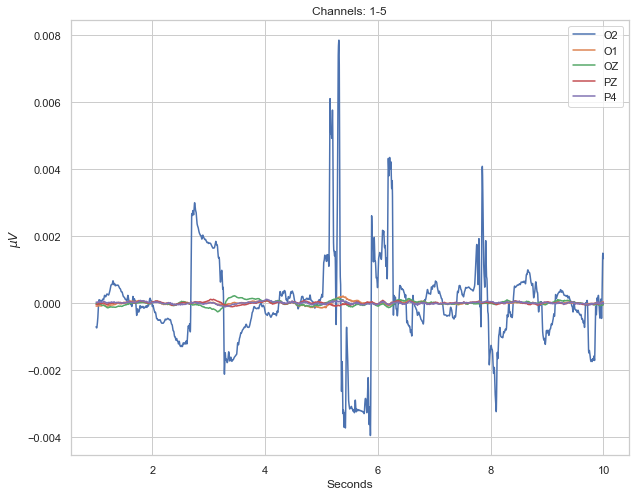

In [34]:
# Extract data from the first 5 channels, from 1 s to 10 s.
sfreq = data_raw.info['sfreq']
data, times = data_raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T)
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5')
plt.legend(data_raw.ch_names[:5])

### mne plots
There are many nice plotting options included in mne. They are, however, not always interactive and fully functional in Jupyter notebooks... so better try them out from a python script.

In [35]:
data_raw.plot(duration=10, block=True)

Using qt as 2D backend.
Opening raw-browser...
Closing raw-browser...
Channels marked as bad:
none


### Look at events 

In [36]:
# get the events
events, event_id = mne.events_from_annotations(data_raw)
print(events[:10,:])
print(event_id)

Used Annotations descriptions: ['4', '5', '77', '88']
[[ 8480     0     1]
 [ 9205     0     1]
 [ 9930     0     1]
 [10656     0     1]
 [11381     0     1]
 [12107     0     1]
 [12832     0     1]
 [13557     0     1]
 [14283     0     3]
 [15008     0     1]]
{'4': 1, '5': 2, '77': 3, '88': 4}


In [37]:
# Check which unique event indentifiers there are
unique_event_types = set(events[:,2])
print(unique_event_types)

{1, 2, 3, 4}


### Search for most common event

In [44]:
tmin = -0.2
tmax = 0.8

baseline = (None, 0)  # means from the first instant to t = 0
counts = pd.Series()

for i, path in enumerate(merged_df['cnt_path']):    # enumerate is a for loop for indeces and content    
    # Import file - not optimized code!
    try:
        raw = mne.io.read_raw_cnt(path, eog='auto', preload=True, verbose=False)
    except: 
        continue
    
    # Load events
    events_count, event_id_count = mne.events_from_annotations(raw, verbose=False)    
    event_id_count = {y:x for x,y in event_id_count.items()}
    
    temp_df = pd.DataFrame(events_count) 
    temp_df[2].replace(event_id_count, inplace=True)
    counts = counts.add(temp_df[2].value_counts(),fill_value=0)

print(counts)

# # 0        3567.0
# # 1       13263.0
# # 10         18.0
# # 104         1.0
# # 11         12.0
# # 112         2.0
# # 12      44920.0
# # 127       304.0
# # 13     120790.0
# # 14       8649.0
# # 15       6600.0
# # 16         13.0
# # 17         13.0
# # 18         93.0
# # 19         75.0
# # 2      357282.0
# # 20         15.0
# # 201         2.0
# # 202         2.0
# # 203         2.0
# # 204         2.0
# # 205         2.0
# # 206         2.0
# # 208         2.0
# # 209         2.0
# # 21         10.0
# # 210         2.0
# # 211         2.0
# # 255         2.0
# # 26          1.0
# # 27          1.0
# # 3      878840.0
# # 31          1.0
# # 33        614.0
# # 35          1.0
# # 36          2.0
# # 4       72045.0
# # 40         12.0
# # 41          4.0
# # 45          1.0
# # 48         18.0
# # 49         10.0
# # 5       55476.0
# # 55      44602.0
# # 58          5.0
# # 6          12.0
# # 60          9.0
# # 65          5.0
# # 66      91848.0
# # 7          12.0
# # 72          4.0
# # 73          7.0
# # 77       8969.0
# # 8          13.0
# # 80         62.0
# # 81         31.0
# # 82          8.0
# # 88       6894.0
# # 9          12.0
# # 99      28749.0
# # dtype: float64

0        3453.0
1        5175.0
10         18.0
104         1.0
11         12.0
12      43307.0
127       304.0
13     116570.0
14       8118.0
15       6123.0
16         13.0
17         13.0
18         33.0
19         35.0
2      343583.0
20         13.0
201         2.0
202         2.0
203         2.0
204         2.0
205         2.0
206         2.0
208         2.0
209         2.0
21          1.0
210         2.0
211         2.0
255         2.0
26          1.0
27          1.0
3      847277.0
33        614.0
35          1.0
36          2.0
4       66954.0
40          3.0
41          3.0
45          1.0
48         13.0
49          8.0
5       50842.0
55      42901.0
58          4.0
6          12.0
60          9.0
65          5.0
66      88540.0
7          12.0
72          2.0
73          1.0
77       8347.0
8          13.0
80         34.0
81         16.0
82          3.0
88       6327.0
9          12.0
99      27648.0
dtype: float64


### Display signal around one type of event
Selects signal for specific event ID and plots time window from tmin to tmax.

In [39]:
# event_id = [1, 2, 3, 4] # select events for the given event IDs
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

baseline = (None, 0)  # means from the first instant to t = 0
picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

print(picks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [40]:
epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=baseline, preload=True, verbose=True)

print(epochs)

Not setting metadata
905 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 905 events and 351 original time points ...
0 bad epochs dropped
<Epochs |  905 events (all good), -0.2 - 0.5 sec, baseline -0.2 – 0 sec, ~150.3 MB, data loaded,
 '4': 455
 '5': 360
 '77': 50
 '88': 40>


In [41]:
# Export data in tabular structure as a pandas DataFrame.
epochs_df = epochs.to_data_frame()
epochs_df.head()

,time,condition,epoch,O2,O1,OZ,PZ,P4,CP4,P8,...,F2,F6,FC5,F1,AF4,AF8,F5,AF7,AF3,FPZ
0,-200,4,0,121.749619,-22.702533,-13.911395,-17.919723,-8.268486,-23.156808,-174.972631,...,-18.473052,-12.814931,-15.543395,-10.980589,-15.755804,-0.547925,-18.004145,-31.841290,-31.047472,-13.786646
1,-198,4,0,122.319915,-23.786131,-16.574190,-18.073577,-7.953233,-22.409743,-171.104146,...,-17.110347,-11.652423,-13.835613,-9.646230,-16.073876,-1.621051,-16.077044,-33.627397,-30.065045,-14.415681
2,-196,4,0,122.151585,-25.111972,-19.718723,-18.415331,-7.776818,-21.834160,-165.398492,...,-16.236077,-11.261978,-13.350664,-9.270093,-16.338038,-2.746268,-15.462611,-35.497049,-29.389001,-15.411788
3,-194,4,0,121.654032,-26.208846,-22.800107,-18.614722,-7.722694,-21.462833,-158.504722,...,-15.905665,-11.622139,-14.091455,-9.931908,-16.421109,-3.601950,-16.219835,-36.920725,-29.050982,-16.484843
4,-192,4,0,121.179952,-26.667395,-25.306402,-18.380310,-7.792512,-21.305265,-151.457825,...,-16.107292,-12.600369,-15.908199,-11.568372,-16.279553,-3.962919,-18.206633,-37.461455,-29.046157,-17.361600


In [42]:
print(epochs)

<Epochs |  905 events (all good), -0.2 - 0.5 sec, baseline -0.2 – 0 sec, ~150.3 MB, data loaded,
 '4': 455
 '5': 360
 '77': 50
 '88': 40>


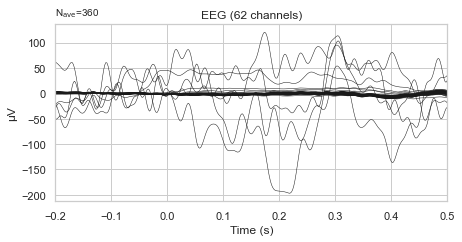

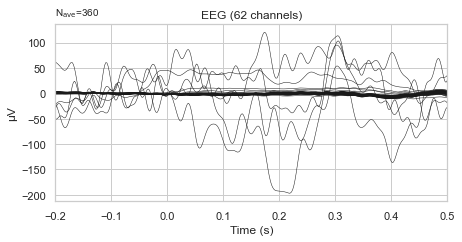

In [43]:
evoked = epochs['5'].average()
evoked.plot()

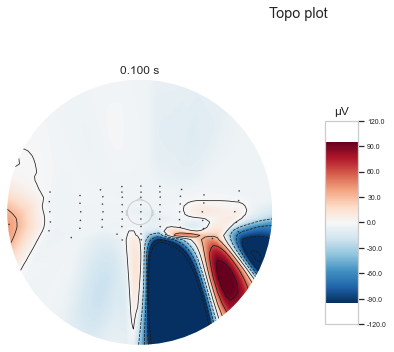

In [45]:
# Spatial plot:
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

### Plot topomaps for different time points

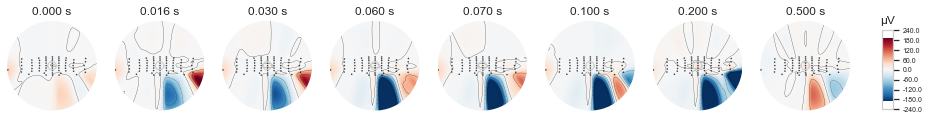

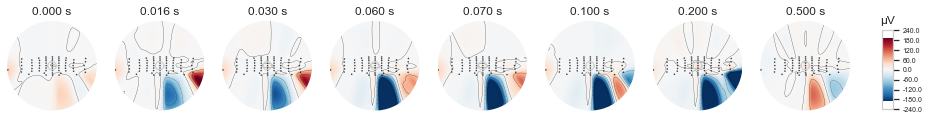

In [46]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

### Test other event type

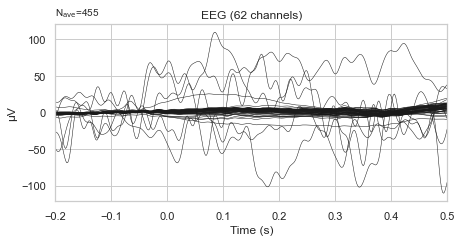

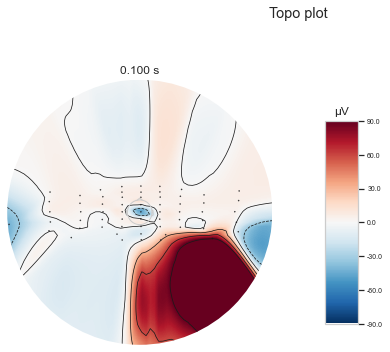

In [47]:
evoked = epochs['4'].average()
evoked.plot()
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

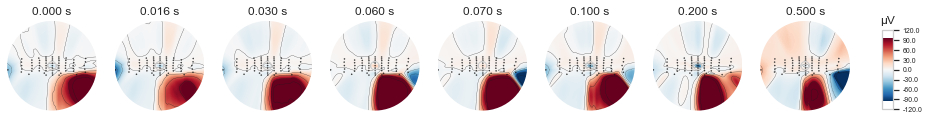

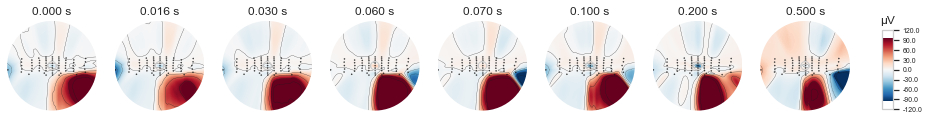

In [48]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

# Adding a montage to the data

Montages specify the exact electrode placement on the scalp of the subject. This contains coordinates relative to a point on the scalp. Often this data is included in the EEG data (.cnt file). Unfortunately for us, we don't have this information. The electrode placement information can be used to fix broken channels by using the channels surrounding this channel. Even though we don't have the exact locations, we do know the electrode placement system used: 10-20. We can use this to approximate the locations.

### When looking at the maps above, the electrode placement seems to be incorrect

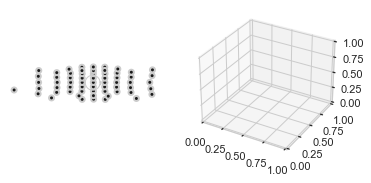

In [49]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
data_raw.plot_sensors(ch_type='eeg', axes=ax2d)
data_raw.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

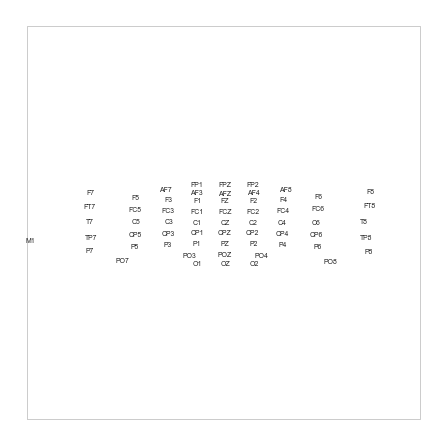

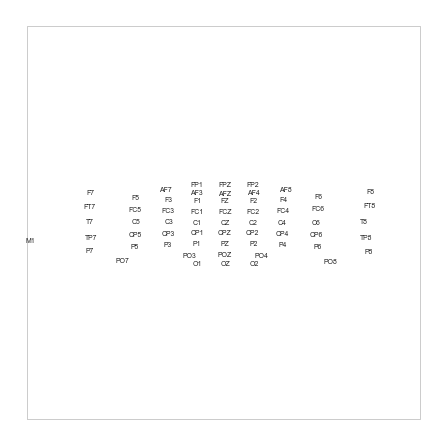

In [50]:
layout_from_raw = mne.channels.make_eeg_layout(data_raw.info)
layout_from_raw.plot()

### Unfortunately, we don't have the exact sensor locations. Therefore, we try to approximate them with a standard montage.

Standard montages come with the mne package. They're based on well known and often used electrode placement systems (10-20 in our case).

In [51]:
print(data_raw.ch_names)

['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'HEOG', 'VEOG', 'AFZ', 'PO3', 'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']


In [52]:
len(data_raw.ch_names)

64

In [53]:
montage = mne.channels.make_standard_montage('standard_1020')
montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


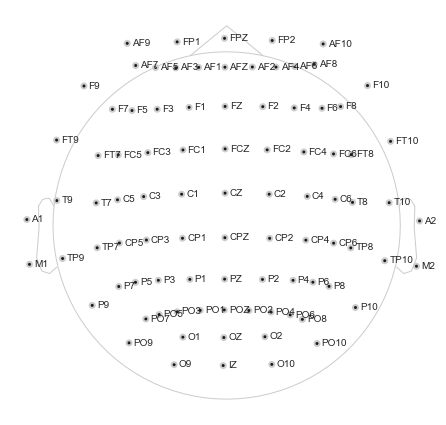

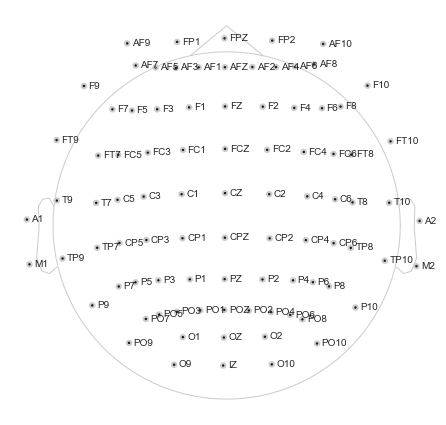

In [54]:
montage.plot(kind='topomap', show_names=True)

In [55]:
data_raw_1020 = data_raw.copy().set_montage(montage)

### Now, after setting the 1020 montage, the maps look different

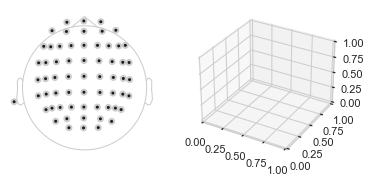

In [56]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
data_raw_1020.plot_sensors(ch_type='eeg', axes=ax2d)
data_raw_1020.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

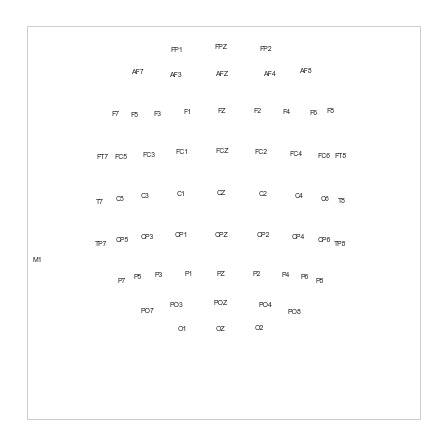

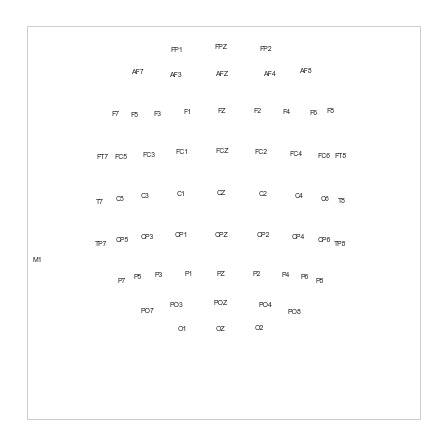

In [57]:
layout_from_raw = mne.channels.make_eeg_layout(data_raw_1020.info)
layout_from_raw.plot()

## Custom cnt-file import function:

In [58]:
# signal_collection = np.zeros((0,3,5))
# signal_collection

In [59]:
def read_cnt_file(file,
                  label_group,
                  event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                  channel_set = "30",
                  tmin = -0.2,
                  tmax = 0.8,
                  lpass = 0.5, 
                  hpass = 40, 
                  threshold = 5, 
                  max_bad_fraction = 0.2,
                  max_bad_channels = 2):
    """ Function to read cnt file. Run bandpass filter. 
    Then detect and correct/remove bad channels and bad epochs.
    Store resulting epochs as arrays.
    
    Args:
    --------
    file: str
        Name of file to import.
    label_group: int
        Unique ID of specific group (must be >0).
    channel_set: str
        Select among pre-defined channel sets. Here: "30" or "62"
    """
    
    if channel_set == "30":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']
    elif channel_set == "62":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 
                       'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 
                       'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 
                       'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']
    else:
        print("Predefined channel set given by 'channel_set' not known...")
        
    
    # Initialize array
    signal_collection = np.zeros((0,len(channel_set),501)) # prepare dimensions of slice, start with zero?
    label_collection = [] #np.zeros((0))
    channel_names_collection = []
    
    # Import file
    try:
        data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True, verbose=False)
    except ValueError:
        print("ValueError")
        print("Could not load file:", file)
        return None, None, None
    
    # Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
    data_raw.filter(0.5, 40, fir_design='firwin')

    # Get events from annotations in the data
    events_from_annot, event_dict = mne.events_from_annotations(data_raw)
    
    # Set baseline:
    baseline = (None, 0)  # means from the first instant to t = 0

    # Select channels to exclude (if any)
    channels_exclude = [x for x in data_raw.ch_names if x not in channel_set]
    channels_exclude = [x for x in channels_exclude if x not in ['HEOG', 'VEOG']]
    
    for event_id in event_idx:
        if str(event_id) in event_dict:
            # Pick EEG channels
            picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                               #exclude=data_exclude)#'bads'])
                                   include=channel_set, exclude=channels_exclude)#'bads'])

            epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                baseline=baseline, preload=True, event_repeated='merge', verbose=False)

            # Detect potential bad channels and epochs
            bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs,
                                                                          event_id,
                                                                          threshold = threshold,
                                                                          max_bad_fraction = max_bad_fraction)

            # Interpolate bad channels
            # ------------------------------------------------------------------
            if len(bad_channels) > 0:
                if len(bad_channels) > max_bad_channels:
                    print(20*'--')
                    print("Found too many bad channels (" + str(len(bad_channels)) + ")")
                    return None, None, None
                else:
                    # MARK: Setting the montage is not verified yet (choice of standard montage)
                    montage = mne.channels.make_standard_montage('standard_1020')
                    montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]
                    data_raw.set_montage(montage)
                    
                    # TODO: Think about using all channels before removing (62 -> 30), to enable for better interpolation
                    
                    # Mark bad channels:
                    data_raw.info['bads'] = bad_channels
                    # Pick EEG channels:
                    picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       #exclude=data_exclude)#'bads'])
                                       include=channel_set, exclude=channels_exclude)#'bads'])
                    epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                        tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                        baseline=baseline, preload=True, verbose=False)
                    
                    # Interpolate bad channels using functionality of 'mne'
                    epochs.interpolate_bads()
                    

            # Get signals as array and add to total collection
            channel_names_collection.append(epochs.ch_names)
            signals_cleaned = epochs[str(event_id)].drop(bad_epochs).get_data()
            # print(signals_cleaned)
            signal_collection = np.concatenate((signal_collection, signals_cleaned), axis=0) # adds to signal collection
            label_collection += [event_id + label_group] * signals_cleaned.shape[0]

    return signal_collection, label_collection, channel_names_collection

In [60]:
#signal_collection -> signal_collect

In [61]:
signal_collect, label_collect, channel_names_collection = read_cnt_file(merged_df['cnt_path'][20], 
                                                                        merged_df['age_months'][0],
                                                                        event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                                        channel_set = "30",
                                                                        tmin = -0.2,
                                                                        tmax = 0.8,
                                                                        lpass = 0.5, 
                                                                        hpass = 40, 
                                                                        threshold = 5, 
                                                                        max_bad_fraction = 0.2,
                                                                        max_bad_channels = 2)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epoch: 31
No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
Found 5 bad epochs in a total of 3  channels.
Marked 5 bad epochs in a total of 400  epochs.
Dropp

In [62]:
signal_collect.shape

(1794, 30, 501)

In [63]:
len(label_collect)

1794

In [64]:
# needs investigation
signal_collect.shape, 

((1794, 30, 501),)

In [65]:
len(label_collect)

1794

In [66]:
# # needs investigation- not defined anywhere
# metadata_collection[:10]

# Feature extraction and save processed data

## Determine how to store the processed data

Below we're determining what the best method is to extract and save the features. At the end, we combine all the parts.

In [70]:
# # cut merged df to test 
# merged_df

In [71]:
# # to test shorter set
# merged_df = merged_df.head(30)
# merged_df

In [69]:
for i, file in merged_df.iterrows():
    
    # Import data and labels
    signal_collect, label_collect, ch_names = read_cnt_file(file['cnt_path'],
                                                            file['age_months'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
        
    # Save data and labels
    # ---------------------------------------------------------
    if signal_collect is None:
        continue
        
    local_processed_data = 'C:/Projects/EEG_explorer/Data/data_processed_ML'

    # Firstly, save the metadata which will be the same for all files derived from this .cnt file
    filename_metadata = os.path.join(local_processed_data, "processed_data_" + file['cnt_file'] + ".csv")
    # create a pandas dataframe out of file, invert rows and columns and outputs a csv at filename_metadata
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)        
    
    # Save all the epochs to separate files
    filename_signal = os.path.join(local_processed_data, "processed_data_" + file['cnt_file'] + ".npy")
    np.save(filename_signal, signal_collect) # save signal collect into .npy file with name on line above
    
    break # MARK: Remove this!

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']
Found 247 bad epochs in a total of 30  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Marked 129 bad epochs in a total of 360  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
In

## Extract features that can be used for machine learning models

In [72]:
from mne_features.feature_extraction import extract_features

### Extract features from the raw data to reduce dimensionality

In [73]:
# User defined functions

def compute_rms(data):
    """Root-mean squared value of the data (per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: *rms*
    """
    return np.sqrt(np.mean(np.power(data, 2), axis=-1))

In [74]:
#import mne_features
# Select features from the raw data for machine learning
selected_features = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'std', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq', 'ptp_amp'}

X_new = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)
# pro
#mne_features.feature_extraction.extract_features(X, sfreq, selected_funcs, funcs_params=None, n_jobs=1, ch_names=None, return_as_df=Fa

In [75]:
X_new

variance                                                          \
              ch0           ch1           ch2           ch3           ch4   
0    1.065674e-09  7.259212e-10  8.861942e-10  8.217166e-10  4.431922e-10   
1    7.854542e-10  6.940606e-10  8.286469e-10  5.145287e-10  7.661265e-10   
2    3.211868e-10  3.285620e-10  3.567020e-10  6.622811e-10  3.441574e-10   
3    9.985962e-10  6.875264e-10  1.054316e-09  6.337947e-10  1.194984e-09   
4    1.876445e-09  1.441694e-09  2.129462e-09  1.327325e-09  7.955484e-10   
..            ...           ...           ...           ...           ...   
831  1.372503e-09  9.043869e-10  1.177603e-09  2.206331e-09  1.578507e-09   
832  4.412364e-09  8.482876e-09  9.884580e-09  7.609879e-09  3.090076e-09   
833  2.350034e-09  4.716526e-09  5.070350e-09  2.577366e-09  1.813177e-09   
834  2.692366e-09  2.818363e-09  2.742674e-09  3.529928e-09  1.414995e-09   
835  4.167894e-09  8.358707e-09  5.409176e-09  7.127711e-09  5.066906e-09   

                                                                           \
              ch5           ch6           ch7           ch8           ch9   
0    6.245328e-10  5.020771e-10  8.399681e-10  9.072447e-10  9.987716e-10   
1    5.194015e-10  8.521632e-10  4.728099e-10  8.380128e-10  5.223748e-10   
2    9.791538e-10  2.254631e-10  2.372893e-09  4.078168e-09  7.136299e-10   
3    5.614984e-09  4.811013e-10  6.967742e-09  5.434830e-10  7.948305e-10   
4    1.940191e-09  1.189162e-09  7.971328e-10  2.702740e-09  1.043103e-09   
..            ...           ...           ...           ...           ...   
831  1.359259e-09  1.221082e-09  4.219196e-09  3.714566e-10  1.246367e-09   
832  5.496073e-09  3.668362e-10  9.219102e-09  1.082111e-08  8.878467e-09   
833  1.732953e-09  1.726660e-09  1.993785e-09  8.511555e-10  1.860700e-09   
834  2.549423e-09  7.794303e-10  2.709044e-09  4.839235e-10  1.781648e-09   
835  8.261416e-09  1.217102e-09  6.636696e-09  3.434778e-09  3.060499e-09   

     ...  kurtosis                                                    \
     ...      ch20      ch21      ch22      ch23      ch24      ch25   
0    ...  2.386865  2.775544  2.485772  2.600876  2.121478  2.600927   
1    ...  5.870361  2.282881  3.469913  8.550614  6.051874  6.099957   
2    ...  2.037460  1.939930  3.620682  2.872714  1.871673  1.941724   
3    ...  2.649076  2.376901  2.972728  2.692514  2.788610  1.977513   
4    ...  2.972250  2.809708  3.047159  1.977909  2.498019  2.688044   
..   ...       ...       ...       ...       ...       ...       ...   
831  ...  1.861529  2.069796  1.738180  2.911759  4.993616  2.061607   
832  ...  2.982480  2.464231  2.337586  2.748342  2.733113  3.498828   
833  ...  1.863695  2.163838  3.710524  2.297174  2.188691  2.240689   
834  ...  2.153656  1.753935  2.035086  1.835298  2.420433  2.030366   
835  ...  3.005893  2.133219  2.061674  2.161830  2.292367  2.732746   

                                             
         ch26      ch27      ch28      ch29  
0    2.219204  2.041160  2.113391  2.021078  
1    1.782554  6.304689  2.039861  3.344856  
2    1.894422  2.399300  1.593146  2.117589  
3    1.960211  2.777081  3.173603  2.024127  
4    2.004160  1.819230  1.839646  1.477660  
..        ...       ...       ...       ...  
831  1.844075  1.472805  4.844332  1.509993  
832  2.943928  2.628649  2.585568  3.055071  
833  3.087754  3.271539  2.477959  3.341343  
834  1.954488  2.958633  1.998713  4.340139  
835  1.852656  2.092548  1.808539  2.167021  

[836 rows x 510 columns]

The raw data had a shape of (1917, 30, 501) - the extracted features data is almost 30 times smaller (before feature selection):

In [76]:
X_new.shape

(836, 510)

### Search for highly correlated features and remove one of them

Some features are often highly correlated and therefore don't add a lot of additional information to the model. To further reduce dimensionality, one of the two highly correlated features can be removed.

In [77]:
X_new_1 = X_new.iloc[:, X_new.columns.get_level_values(1)=='1']

In [78]:
# Select only the first channel for all features

X_new_1

0
1
2
3
4
...
831
832
833
834
835


In [79]:
#correlation = X_new_1.corr()
correlation = X_new.corr()

<AxesSubplot:xlabel='None-None', ylabel='None-None'>

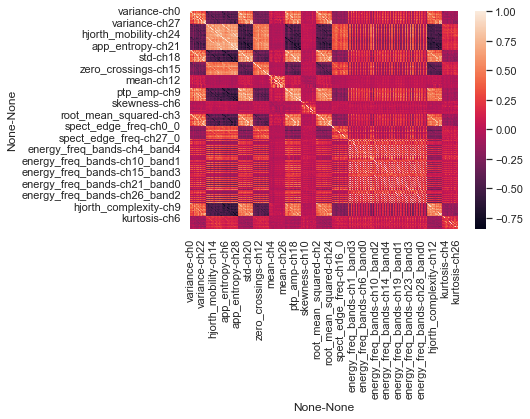

In [80]:
sns.heatmap(correlation)

In [81]:
correlation

variance                                                    \
                    ch0       ch1       ch2       ch3       ch4       ch5   
variance ch0   1.000000  0.598840  0.730842  0.450571  0.464780  0.381684   
         ch1   0.598840  1.000000  0.863349  0.584734  0.487778  0.409931   
         ch2   0.730842  0.863349  1.000000  0.540938  0.421106  0.353076   
         ch3   0.450571  0.584734  0.540938  1.000000  0.607552  0.597943   
         ch4   0.464780  0.487778  0.421106  0.607552  1.000000  0.745499   
...                 ...       ...       ...       ...       ...       ...   
kurtosis ch25 -0.085577 -0.093300 -0.102949 -0.130859 -0.089979 -0.111119   
         ch26 -0.042475 -0.077369 -0.067213 -0.086335 -0.044548 -0.047875   
         ch27 -0.045524 -0.077757 -0.088105 -0.063960 -0.028708 -0.039575   
         ch28 -0.065944 -0.106603 -0.097054 -0.062039 -0.051405 -0.068681   
         ch29 -0.026039 -0.073012 -0.062507 -0.040470  0.000111 -0.007616   

                                                       ...  kurtosis  \
                    ch6       ch7       ch8       ch9  ...      ch20   
variance ch0   0.269796  0.418734  0.210222  0.255794  ... -0.017529   
         ch1   0.225711  0.454060  0.222238  0.275804  ... -0.045880   
         ch2   0.171750  0.413198  0.203807  0.236017  ... -0.034907   
         ch3   0.263285  0.680441  0.274361  0.424137  ... -0.038455   
         ch4   0.459022  0.641019  0.294191  0.334906  ... -0.019919   
...                 ...       ...       ...       ...  ...       ...   
kurtosis ch25  0.032779 -0.138399 -0.086478 -0.105156  ...  0.477959   
         ch26 -0.072723 -0.118043 -0.134426 -0.153061  ...  0.497158   
         ch27  0.038378 -0.014350 -0.011243 -0.012782  ...  0.239961   
         ch28 -0.053484 -0.071909 -0.071063 -0.099257  ...  0.215721   
         ch29  0.037810  0.002119 -0.019010  0.010976  ...  0.142665   

                                                                           \
                   ch21      ch22      ch23      ch24      ch25      ch26   
variance ch0  -0.050706 -0.014976 -0.131721 -0.092969 -0.085577 -0.042475   
         ch1  -0.114292 -0.048258 -0.142835 -0.134061 -0.093300 -0.077369   
         ch2  -0.110113 -0.047287 -0.142483 -0.127008 -0.102949 -0.067213   
         ch3  -0.077916 -0.039704 -0.141823 -0.116323 -0.130859 -0.086335   
         ch4  -0.016751  0.007486 -0.104842 -0.054959 -0.089979 -0.044548   
...                 ...       ...       ...       ...       ...       ...   
kurtosis ch25  0.360000  0.209708  0.327463  0.340307  1.000000  0.588730   
         ch26  0.555389  0.303779  0.299068  0.403892  0.588730  1.000000   
         ch27  0.361629  0.565838  0.172563  0.188201  0.197614  0.251733   
         ch28  0.403532  0.187757  0.389499  0.596122  0.251378  0.482378   
         ch29  0.279877  0.421764  0.176570  0.204402  0.110901  0.225343   

                                             
                   ch27      ch28      ch29  
variance ch0  -0.045524 -0.065944 -0.026039  
         ch1  -0.077757 -0.106603 -0.073012  
         ch2  -0.088105 -0.097054 -0.062507  
         ch3  -0.063960 -0.062039 -0.040470  
         ch4  -0.028708 -0.051405  0.000111  
...                 ...       ...       ...  
kurtosis ch25  0.197614  0.251378  0.110901  
         ch26  0.251733  0.482378  0.225343  
         ch27  1.000000  0.280788  0.739098  
         ch28  0.280788  1.000000  0.330185  
         ch29  0.739098  0.330185  1.000000  

[510 rows x 510 columns]

In [82]:
correlation.ge(0.9)

"""
Highly correlated (>0.90), channel 0:
- std & rms (0.926)
- std & ptp_amp (0.9688)
- std & variance (0.952)
- ptp_amp & variance (0.900)

Highly correlated (>0.90), channel 1:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance

Highly correlated (>0.90), channel 2:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance

Highly correlated (>0.90), channel 3:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 3:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 4:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 5:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance
"""

'\nHighly correlated (>0.90), channel 0:\n- std & rms (0.926)\n- std & ptp_amp (0.9688)\n- std & variance (0.952)\n- ptp_amp & variance (0.900)\n\nHighly correlated (>0.90), channel 1:\nstd & rms\nstd & ptp_amp\nstd & variance\nrms & ptp_amp\nptp_amp & variance\n\nHighly correlated (>0.90), channel 2:\nstd & rms\nstd & ptp_amp\nstd & variance\nrms & ptp_amp\nptp_amp & variance\n\nHighly correlated (>0.90), channel 3:\nstd & rms\nstd & ptp_amp\nstd & variance\nptp_amp & variance\n\nHighly correlated (>0.90), channel 3:\nstd & rms\nstd & ptp_amp\nstd & variance\nptp_amp & variance\n\nHighly correlated (>0.90), channel 4:\nstd & rms\nstd & ptp_amp\nstd & variance\nptp_amp & variance\n\nHighly correlated (>0.90), channel 5:\nstd & rms\nstd & ptp_amp\nstd & variance\nrms & ptp_amp\nptp_amp & variance\n'

After inspecting a few channels and the correlation between the features, the features 'std' and 'ptp_amp' can be removed, because they have a high correlation with eachother, 'rms' and 'variance'. Removing these two features will reduce the dimensionality.

### Feature extraction after selection

In [83]:
# Removed features: std, ptp_amp
selected_features_selection = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq'}

X_new_selection = extract_features(signal_collect, 500.0, selected_features_selection, return_as_df=1)

In [84]:
X_new_selection

variance                                                          \
              ch0           ch1           ch2           ch3           ch4   
0    1.065674e-09  7.259212e-10  8.861942e-10  8.217166e-10  4.431922e-10   
1    7.854542e-10  6.940606e-10  8.286469e-10  5.145287e-10  7.661265e-10   
2    3.211868e-10  3.285620e-10  3.567020e-10  6.622811e-10  3.441574e-10   
3    9.985962e-10  6.875264e-10  1.054316e-09  6.337947e-10  1.194984e-09   
4    1.876445e-09  1.441694e-09  2.129462e-09  1.327325e-09  7.955484e-10   
..            ...           ...           ...           ...           ...   
831  1.372503e-09  9.043869e-10  1.177603e-09  2.206331e-09  1.578507e-09   
832  4.412364e-09  8.482876e-09  9.884580e-09  7.609879e-09  3.090076e-09   
833  2.350034e-09  4.716526e-09  5.070350e-09  2.577366e-09  1.813177e-09   
834  2.692366e-09  2.818363e-09  2.742674e-09  3.529928e-09  1.414995e-09   
835  4.167894e-09  8.358707e-09  5.409176e-09  7.127711e-09  5.066906e-09   

                                                                           \
              ch5           ch6           ch7           ch8           ch9   
0    6.245328e-10  5.020771e-10  8.399681e-10  9.072447e-10  9.987716e-10   
1    5.194015e-10  8.521632e-10  4.728099e-10  8.380128e-10  5.223748e-10   
2    9.791538e-10  2.254631e-10  2.372893e-09  4.078168e-09  7.136299e-10   
3    5.614984e-09  4.811013e-10  6.967742e-09  5.434830e-10  7.948305e-10   
4    1.940191e-09  1.189162e-09  7.971328e-10  2.702740e-09  1.043103e-09   
..            ...           ...           ...           ...           ...   
831  1.359259e-09  1.221082e-09  4.219196e-09  3.714566e-10  1.246367e-09   
832  5.496073e-09  3.668362e-10  9.219102e-09  1.082111e-08  8.878467e-09   
833  1.732953e-09  1.726660e-09  1.993785e-09  8.511555e-10  1.860700e-09   
834  2.549423e-09  7.794303e-10  2.709044e-09  4.839235e-10  1.781648e-09   
835  8.261416e-09  1.217102e-09  6.636696e-09  3.434778e-09  3.060499e-09   

     ...  kurtosis                                                    \
     ...      ch20      ch21      ch22      ch23      ch24      ch25   
0    ...  2.386865  2.775544  2.485772  2.600876  2.121478  2.600927   
1    ...  5.870361  2.282881  3.469913  8.550614  6.051874  6.099957   
2    ...  2.037460  1.939930  3.620682  2.872714  1.871673  1.941724   
3    ...  2.649076  2.376901  2.972728  2.692514  2.788610  1.977513   
4    ...  2.972250  2.809708  3.047159  1.977909  2.498019  2.688044   
..   ...       ...       ...       ...       ...       ...       ...   
831  ...  1.861529  2.069796  1.738180  2.911759  4.993616  2.061607   
832  ...  2.982480  2.464231  2.337586  2.748342  2.733113  3.498828   
833  ...  1.863695  2.163838  3.710524  2.297174  2.188691  2.240689   
834  ...  2.153656  1.753935  2.035086  1.835298  2.420433  2.030366   
835  ...  3.005893  2.133219  2.061674  2.161830  2.292367  2.732746   

                                             
         ch26      ch27      ch28      ch29  
0    2.219204  2.041160  2.113391  2.021078  
1    1.782554  6.304689  2.039861  3.344856  
2    1.894422  2.399300  1.593146  2.117589  
3    1.960211  2.777081  3.173603  2.024127  
4    2.004160  1.819230  1.839646  1.477660  
..        ...       ...       ...       ...  
831  1.844075  1.472805  4.844332  1.509993  
832  2.943928  2.628649  2.585568  3.055071  
833  3.087754  3.271539  2.477959  3.341343  
834  1.954488  2.958633  1.998713  4.340139  
835  1.852656  2.092548  1.808539  2.167021  

[836 rows x 450 columns]

In [85]:
X_new_selection.columns

MultiIndex([('variance',  'ch0'),
            ('variance',  'ch1'),
            ('variance',  'ch2'),
            ('variance',  'ch3'),
            ('variance',  'ch4'),
            ('variance',  'ch5'),
            ('variance',  'ch6'),
            ('variance',  'ch7'),
            ('variance',  'ch8'),
            ('variance',  'ch9'),
            ...
            ('kurtosis', 'ch20'),
            ('kurtosis', 'ch21'),
            ('kurtosis', 'ch22'),
            ('kurtosis', 'ch23'),
            ('kurtosis', 'ch24'),
            ('kurtosis', 'ch25'),
            ('kurtosis', 'ch26'),
            ('kurtosis', 'ch27'),
            ('kurtosis', 'ch28'),
            ('kurtosis', 'ch29')],
           length=450)

The different channels aren't identifiable by the current naming method. Map the numbers to the actual channel name and flatten the MultiIndex column dataframe.

In [86]:
channel_names_collection[0]

['O2',
 'O1',
 'OZ',
 'PZ',
 'P4',
 'CP4',
 'P8',
 'C4',
 'TP8',
 'T8',
 'P7',
 'P3',
 'CP3',
 'CPZ',
 'CZ',
 'FC4',
 'FT8',
 'TP7',
 'C3',
 'FCZ',
 'FZ',
 'F4',
 'F8',
 'T7',
 'FT7',
 'FC3',
 'F3',
 'FP2',
 'F7',
 'FP1']

In [87]:
# Update the column names

import re

def flatten_multiindex(multiindex):
    cols = []

    for category, subcategory in multiindex:
        # energy_freq_bands features
        if '_' in subcategory:
            prefix, suffix = subcategory.split('_')
        else:
            prefix, suffix = subcategory, None
        start, end = re.search(r'\d+', prefix).span()
        chindex = int(prefix[start:end])
        channel = channel_names_collection[0][chindex]
        colname = '_'.join(c for c in (category, suffix, channel) if c)
        cols.append(colname)
    return cols

In [88]:
X_new_selection.columns = flatten_multiindex(X_new_selection.columns)

In [89]:
X_new_selection.columns

Index(['variance_O2', 'variance_O1', 'variance_OZ', 'variance_PZ',
       'variance_P4', 'variance_CP4', 'variance_P8', 'variance_C4',
       'variance_TP8', 'variance_T8',
       ...
       'kurtosis_FZ', 'kurtosis_F4', 'kurtosis_F8', 'kurtosis_T7',
       'kurtosis_FT7', 'kurtosis_FC3', 'kurtosis_F3', 'kurtosis_FP2',
       'kurtosis_F7', 'kurtosis_FP1'],
      dtype='object', length=450)

# Putting the feature extraction, selection and saving steps together

Steps:

1. Check if files don't already exist
2. Load EEG data
3. Extract features
4. Save metadata, save features dataframe

In [98]:
local_processed_data2= 'C:/Projects/EEG_explorer/Data/data_processed_ML2'
local_processed_data = 'C:/Projects/EEG_explorer/Data/data_processed_ML'

In [99]:
# TODO: Check the band ranges used
selected_features = {
    'mean',
    ('root_mean_squared', compute_rms),
    'hjorth_mobility',
    'hjorth_complexity',
    'variance',
    'kurtosis',
    'skewness',
    'app_entropy',
    'zero_crossings',
    'energy_freq_bands',
    'spect_edge_freq',
}

for i, file in merged_df.iterrows():
    print(f"Checking out file: {file['cnt_file']}")
        
    filename_extracted_features = os.path.join(local_processed_data2, f"extracted_features_{file['cnt_file']}.h5")
    filename_metadata = os.path.join(local_processed_data2, f"processed_data_{file['cnt_file']}.csv")
    
    # Step 1: Check if file don't already exist, else skip
    if os.path.exists(filename_extracted_features) and os.path.exists(filename_metadata):
        print(f"Skipping because {filename_extracted_features} and {filename_metadata} already exist.")
        continue

    # Step 2: Import data and labels 
    signal_collect, label_collect, ch_names = read_cnt_file(
        file['cnt_path'],
        file['age_months'],
        event_idx=[2, 3, 4, 5, 12, 13, 14, 15],
        channel_set="30",
        tmin=-0.2,
        tmax=0.8,
        lpass=0.5,
        hpass=40,
        threshold=5,
        max_bad_fraction=0.2,
        max_bad_channels=2,
    )    
    
    if signal_collect is None:
        continue
    
    # Step 3: Extract the features from the raw data
    try:
        extracted_features = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)

    except:
        print(f"Skipping because {file['cnt_file']} causes error when extracting features.")
        continue
    
    # Change the DataFrame from hierarchical column structure ('mean' -> ch1, ch2, ch3) 
    # to flat column structure ('mean-ch1', 'mean-ch2', etc..)

    extracted_features.columns = flatten_multiindex(extracted_features.columns)
    
    # Step 4: Save metadata (same for all files derived from this .cnt file), save the extracted features
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)     
    extracted_features.to_hdf(filename_extracted_features, key='df', mode='w')
    # TODO: 1. Try saving 2. Retry after n seconds if fails 3. If fails m times, continue
    print(len(extracted_features))
    
        


Checking out file: 001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']
Found 247 bad epochs in a total of 30  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Marked 129 bad epochs in a total of 360  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 9

TypeError: _getfullpathname: path should be string, bytes or os.PathLike, not float

In [100]:
extracted_features

,variance_O2,variance_O1,variance_OZ,variance_PZ,variance_P4,variance_CP4,variance_P8,variance_C4,variance_TP8,variance_T8,...,kurtosis_FZ,kurtosis_F4,kurtosis_F8,kurtosis_T7,kurtosis_FT7,kurtosis_FC3,kurtosis_F3,kurtosis_FP2,kurtosis_F7,kurtosis_FP1
0,5.022464e-09,6.747249e-09,6.671015e-09,8.703251e-09,2.288278e-09,1.578449e-09,2.208841e-09,6.964228e-09,1.563412e-10,4.395433e-10,...,2.511616,1.818110,1.938062,2.558769,2.356610,1.791852,2.553729,2.656570,2.204714,2.391004
1,2.960171e-09,2.271128e-09,2.442874e-09,9.353418e-09,1.508587e-09,2.936085e-09,1.609166e-09,4.309758e-09,8.331134e-10,8.082327e-10,...,1.721097,1.707206,2.055277,1.992610,1.974575,2.524890,1.946379,1.855308,2.162321,2.191468
2,1.633513e-09,1.104946e-09,5.063382e-10,9.806646e-10,7.873969e-10,3.394164e-09,1.217846e-09,2.104450e-09,2.569351e-10,9.810608e-11,...,2.225123,1.702636,2.159457,2.153203,1.300564,2.550986,2.501687,2.024232,1.416841,2.884398
3,3.423688e-10,7.789754e-10,3.517267e-10,2.697715e-09,1.037196e-09,1.209658e-09,4.281628e-10,1.332082e-09,5.063036e-10,3.038633e-10,...,1.981047,2.341879,2.581475,1.962502,1.993236,2.230072,2.065432,2.760173,1.932941,2.431588
4,5.763596e-10,6.758514e-10,5.335467e-10,2.340188e-09,6.792797e-10,8.698905e-10,5.464030e-10,1.497395e-09,4.407584e-10,9.461831e-10,...,1.995483,1.543010,2.561298,1.858303,1.686595,1.978106,2.881025,2.303920,2.215192,1.907779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1.182393e-08,9.367555e-09,1.254617e-08,2.674742e-09,1.602863e-09,2.016624e-09,2.340971e-09,1.432011e-09,2.306737e-10,1.402208e-10,...,2.701261,1.573869,1.526623,2.424311,1.931587,1.874625,1.850876,2.729181,1.510111,1.908288
1748,6.963178e-10,2.913034e-09,1.937635e-09,3.767214e-09,2.485163e-09,2.710681e-09,8.208982e-10,1.607517e-09,4.266522e-10,4.010246e-10,...,4.079995,3.745064,2.536711,2.492185,2.166303,3.759166,4.100517,4.847580,2.060514,4.799664
1749,1.739136e-09,2.413339e-09,1.651179e-09,1.156871e-09,1.870326e-09,1.296521e-09,1.420349e-09,1.198356e-09,4.081763e-10,1.037952e-09,...,2.434361,3.494130,3.834535,2.405260,2.401291,3.392073,2.601416,3.758070,2.624782,3.343716
1750,1.762718e-09,1.459993e-09,1.356780e-09,1.454071e-09,6.191306e-10,7.546660e-10,6.117438e-10,1.129553e-09,1.595444e-10,7.745630e-10,...,2.891918,2.155864,2.822357,2.104684,2.084963,2.182259,2.056860,2.282618,1.606629,2.184198


In [101]:
extracted_features.columns

Index(['variance_O2', 'variance_O1', 'variance_OZ', 'variance_PZ',
       'variance_P4', 'variance_CP4', 'variance_P8', 'variance_C4',
       'variance_TP8', 'variance_T8',
       ...
       'kurtosis_FZ', 'kurtosis_F4', 'kurtosis_F8', 'kurtosis_T7',
       'kurtosis_FT7', 'kurtosis_FC3', 'kurtosis_F3', 'kurtosis_FP2',
       'kurtosis_F7', 'kurtosis_FP1'],
      dtype='object', length=450)

In [93]:
# col_names = []

# for i, j in extracted_features.columns:
#     col_names.append(f'{i}_{j}')
# col_names
        

In [94]:
# extracted_feat

In [102]:
#extracted_feat

In [103]:
    # Change the DataFrame from hierarchical column structure ('mean' -> ch1, ch2, ch3) 
    # to flat column structure ('mean-ch1', 'mean-ch2', etc..)
#     col_names = []

#     for i, j in extracted_features.columns:
#         try:
#             col_names.append(f'{i}_{channel_names_collection[0][int(j)]}')
#         except ValueError:
#             # energy_freq_bands feature has different naming
#             str_parts = j.split('_')        
#             ch_num = re.findall("\d+", str_parts[0])[0]
#             col_names.append(f'{i}_{str_parts[1]}_{channel_names_collection[0][int(ch_num)]}')
        
# extracted_features.columns = col_names
    
#     # Step 4: Save metadata (same for all files derived from this .cnt file), save the extracted features
# pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)     
# extracted_features.to_hdf(filename_extracted_features, key='df', mode='w')
#     # TODO: 1. Try saving 2. Retry after n seconds if fails 3. If fails m times, continue

In [104]:
extracted_features

,variance_O2,variance_O1,variance_OZ,variance_PZ,variance_P4,variance_CP4,variance_P8,variance_C4,variance_TP8,variance_T8,...,kurtosis_FZ,kurtosis_F4,kurtosis_F8,kurtosis_T7,kurtosis_FT7,kurtosis_FC3,kurtosis_F3,kurtosis_FP2,kurtosis_F7,kurtosis_FP1
0,5.022464e-09,6.747249e-09,6.671015e-09,8.703251e-09,2.288278e-09,1.578449e-09,2.208841e-09,6.964228e-09,1.563412e-10,4.395433e-10,...,2.511616,1.818110,1.938062,2.558769,2.356610,1.791852,2.553729,2.656570,2.204714,2.391004
1,2.960171e-09,2.271128e-09,2.442874e-09,9.353418e-09,1.508587e-09,2.936085e-09,1.609166e-09,4.309758e-09,8.331134e-10,8.082327e-10,...,1.721097,1.707206,2.055277,1.992610,1.974575,2.524890,1.946379,1.855308,2.162321,2.191468
2,1.633513e-09,1.104946e-09,5.063382e-10,9.806646e-10,7.873969e-10,3.394164e-09,1.217846e-09,2.104450e-09,2.569351e-10,9.810608e-11,...,2.225123,1.702636,2.159457,2.153203,1.300564,2.550986,2.501687,2.024232,1.416841,2.884398
3,3.423688e-10,7.789754e-10,3.517267e-10,2.697715e-09,1.037196e-09,1.209658e-09,4.281628e-10,1.332082e-09,5.063036e-10,3.038633e-10,...,1.981047,2.341879,2.581475,1.962502,1.993236,2.230072,2.065432,2.760173,1.932941,2.431588
4,5.763596e-10,6.758514e-10,5.335467e-10,2.340188e-09,6.792797e-10,8.698905e-10,5.464030e-10,1.497395e-09,4.407584e-10,9.461831e-10,...,1.995483,1.543010,2.561298,1.858303,1.686595,1.978106,2.881025,2.303920,2.215192,1.907779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1.182393e-08,9.367555e-09,1.254617e-08,2.674742e-09,1.602863e-09,2.016624e-09,2.340971e-09,1.432011e-09,2.306737e-10,1.402208e-10,...,2.701261,1.573869,1.526623,2.424311,1.931587,1.874625,1.850876,2.729181,1.510111,1.908288
1748,6.963178e-10,2.913034e-09,1.937635e-09,3.767214e-09,2.485163e-09,2.710681e-09,8.208982e-10,1.607517e-09,4.266522e-10,4.010246e-10,...,4.079995,3.745064,2.536711,2.492185,2.166303,3.759166,4.100517,4.847580,2.060514,4.799664
1749,1.739136e-09,2.413339e-09,1.651179e-09,1.156871e-09,1.870326e-09,1.296521e-09,1.420349e-09,1.198356e-09,4.081763e-10,1.037952e-09,...,2.434361,3.494130,3.834535,2.405260,2.401291,3.392073,2.601416,3.758070,2.624782,3.343716
1750,1.762718e-09,1.459993e-09,1.356780e-09,1.454071e-09,6.191306e-10,7.546660e-10,6.117438e-10,1.129553e-09,1.595444e-10,7.745630e-10,...,2.891918,2.155864,2.822357,2.104684,2.084963,2.182259,2.056860,2.282618,1.606629,2.184198


### Sanity check: test loading the saved file from disk

In [105]:
# df_load = pd.read_hdf(os.path.join(PATH_DATA_PROCESSED_ML,"extracted_features_009_11_jc_mmn36_wk_mmn25_wk.h5"))
# needs to check a particular file it worked for

df_load = pd.read_hdf(os.path.join(PATH_DATA_PROCESSED_ML,"extracted_features_005_11_jc_mmn2.h5"))

In [106]:
df_load

,hjorth_mobility_ch0,hjorth_mobility_ch1,hjorth_mobility_ch2,hjorth_mobility_ch3,hjorth_mobility_ch4,hjorth_mobility_ch5,hjorth_mobility_ch6,hjorth_mobility_ch7,hjorth_mobility_ch8,hjorth_mobility_ch9,...,variance_ch20,variance_ch21,variance_ch22,variance_ch23,variance_ch24,variance_ch25,variance_ch26,variance_ch27,variance_ch28,variance_ch29
0,0.152658,0.194923,0.183333,0.174530,0.247460,0.207661,0.336606,0.191720,0.243473,0.305497,...,8.044913e-10,9.594264e-10,6.234305e-10,8.803025e-10,8.188227e-10,8.459284e-10,7.256248e-10,1.071955e-09,1.096879e-09,1.369324e-09
1,0.210982,0.210451,0.192192,0.249058,0.218023,0.266741,0.289559,0.271192,0.245614,0.321758,...,4.351266e-10,1.644958e-09,6.741005e-10,5.886501e-10,5.174767e-10,5.426035e-10,1.069715e-09,3.566241e-10,9.525833e-10,6.309847e-10
2,0.164608,0.151855,0.155277,0.108446,0.168379,0.095597,0.239119,0.062347,0.068967,0.234310,...,7.648657e-10,5.858870e-09,3.550096e-10,6.602802e-10,1.903532e-09,1.036956e-09,2.028207e-09,6.020847e-10,2.758479e-09,1.673598e-09
3,0.120889,0.123352,0.116103,0.124828,0.090709,0.064094,0.183740,0.038186,0.176192,0.195904,...,8.876180e-10,1.204443e-09,4.984316e-10,6.989546e-10,4.337724e-10,2.901666e-09,1.595319e-09,5.735673e-10,4.297960e-09,4.611585e-09
4,0.070541,0.077816,0.064885,0.082533,0.112912,0.075339,0.114245,0.121118,0.085468,0.177550,...,6.971193e-10,4.050231e-10,6.707648e-10,1.493879e-09,6.072337e-10,1.569691e-09,8.177346e-10,2.199050e-09,6.320566e-10,5.022906e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,0.064319,0.063033,0.058120,0.036040,0.062285,0.066757,0.065923,0.046128,0.150537,0.069854,...,1.214620e-08,6.240639e-09,2.090511e-09,1.589240e-09,2.272736e-09,6.113405e-09,7.067364e-09,4.172144e-09,2.267036e-09,3.539732e-09
832,0.038638,0.031440,0.028327,0.036559,0.044891,0.037414,0.134561,0.026502,0.023343,0.024066,...,1.832989e-08,8.042182e-09,5.013324e-09,4.731754e-09,8.787900e-09,1.332479e-08,9.105891e-09,4.634802e-09,1.087008e-08,4.510512e-09
833,0.048896,0.035272,0.036187,0.048143,0.057271,0.065214,0.054158,0.057122,0.101206,0.055446,...,9.289229e-09,1.567340e-09,2.431650e-09,1.718375e-09,1.560676e-09,3.721780e-09,3.082723e-09,2.648969e-09,2.515206e-09,2.972745e-09
834,0.043521,0.037755,0.043035,0.030436,0.051969,0.034198,0.055526,0.034892,0.110651,0.051632,...,4.710824e-09,1.048124e-09,5.506604e-10,1.092522e-09,8.752349e-10,3.751164e-09,1.486598e-09,3.594643e-10,4.987367e-10,5.873856e-10


In [107]:
2+2


4